In [68]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [69]:
df = pd.read_csv('../datasets/teen_phone_addiction_dataset.csv')
data_series = df['Time_on_Social_Media']

Рассчитайте характеристики:

Среднее
Дисперсия
Мода
Медиана
Квантили 
уровня 
0.25, 0.5, 0.75
Эксцесс
Ассиметрия
Интерквартильный размах

In [70]:
print("Среднее значение", data_series.mean())
print("Дисперсия", data_series.var())
print("Мода", data_series.mode()[0] if not data_series.mode().empty else np.nan)
print("Медиана", data_series.median())
quantilies = data_series.quantile([0.25, 0.5, 0.75])
print("Квантили", quantilies.values)
print("Эксцесс",stats.kurtosis(data_series, bias=False))
print("Ассиметрия", stats.skew(data_series, bias=False))
print("Интерквартильный размах", quantilies[0.75] - quantilies[0.25])

Среднее значение 2.4992333333333336
Дисперсия 0.9765415927531399
Мода 2.7
Медиана 2.5
Квантили [1.8 2.5 3.2]
Эксцесс -0.21322979611749737
Ассиметрия 0.06697299104625637
Интерквартильный размах 1.4000000000000001


In [71]:
print(len(data_series))

3000


Среднее значение, мода и медиана фактически совпадают, думаю выборка достаточно большая, чтобы считать отклонение незначительной.<br>
Коэффициент ассиметрии близок к нулю, но всё же немного болбше => у распределения малая скошенность вправо, но оноо близко к симметричному.<br>
Эксцесс лежит в пределах от -0.5 до 3 => распределние близко к нормальному распределению.<br>
Небольшая дисперсия и интерквартильный разброс: большинство данных лежат в интервале от 1.8 до 3.2

Гистограмма и эмперичская функция распределения

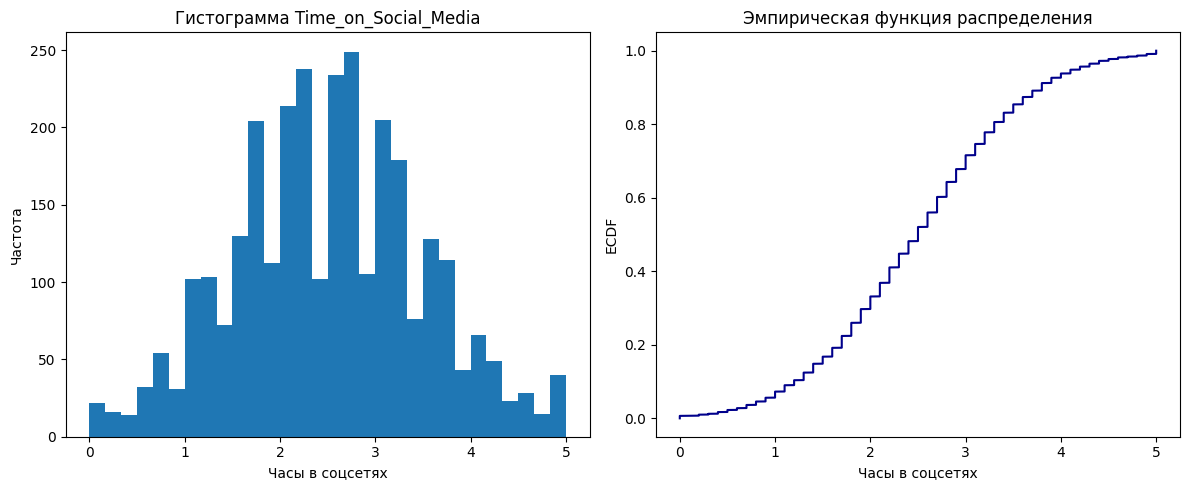

In [72]:
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.hist(data_series, bins = 30)
plt.title('Гистограмма Time_on_Social_Media')
plt.xlabel('Часы в соцсетях')
plt.ylabel('Частота')

plt.subplot(1, 2, 2)
sorted_data = np.sort(data_series)
y = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
plt.plot(sorted_data, y, color='darkblue')
plt.title('Эмпирическая функция распределения')
plt.xlabel('Часы в соцсетях')
plt.ylabel('ECDF')

plt.tight_layout()
plt.show()


Критерий Хи квадрат

Пометка для себя:<br>
Критерий хи-квадрат проверяет, насколько данные соответствуют теоретическому распределению (в данном случае нормальному). Мы сравниваем наблюдаемые частоты (сколько раз значения попадают в определённые интервалы) с ожидаемыми частотами (как они должны быть при нормальном распределении).

In [73]:
mean = data_series.mean()
std = np.sqrt(data_series.var())
n = len(data_series)

In [74]:
#Разбиваем данные на интервалы
bins = 10
hist, bin_edges = np.histogram(data_series, bins = bins, density=False)
observed = hist #наблюдаемые частоты

In [75]:
#Вычисляем ожидаемые частоты
expected = []
for i in range(len(bin_edges) - 1):
    left = bin_edges[i]
    right = bin_edges[i + 1]
    prob = stats.norm.cdf(right, mean, std) - stats.norm.cdf(left, mean, std)
    expected.append(prob * n)


expected = np.array(expected)

In [76]:
if any(e < 5 for e in expected):
    print("Предупреждение: некоторые ожидаемые частоты < 5, попробуйте увеличить bins или объединить интервалы")

In [77]:
#Статистика хи-квадрат
chi_square_stat = np.sum((observed - expected) ** 2 / expected)
df_chi = len(observed) - 1 - 2 #Степени свободы
critical_value = stats.chi2.ppf(1 - 0.05, df_chi) #критическое значение

In [78]:
print("Критерий хи-квадрат:")
print(f"Статистика хи-квадрат: {chi_square_stat:.2f}")
print(f"Критическое значение (alpha=0.05, df={df_chi}): {critical_value:.2f}")
if chi_square_stat > critical_value:
    print("Отвергаем гипотезу о нормальности (данные не нормальны)")
else:
    print("Не отвергаем гипотезу о нормальности")

Критерий хи-квадрат:
Статистика хи-квадрат: 31.32
Критическое значение (alpha=0.05, df=7): 14.07
Отвергаем гипотезу о нормальности (данные не нормальны)


Выводы по эксцессе и ассиметрии я сделала ещё выше

Пометка для себя:<br>
Q-Q plot (quantile-quantile plot, график квантиль-квантиль) — это визуальный инструмент для проверки, соответствует ли распределение данных какому-либо теоретическому распределению, чаще всего нормальному. Он сравнивает квантили данных (значения, которые делят данные на равные доли) с квантилями теоретического распределения (в твоём случае — нормального)

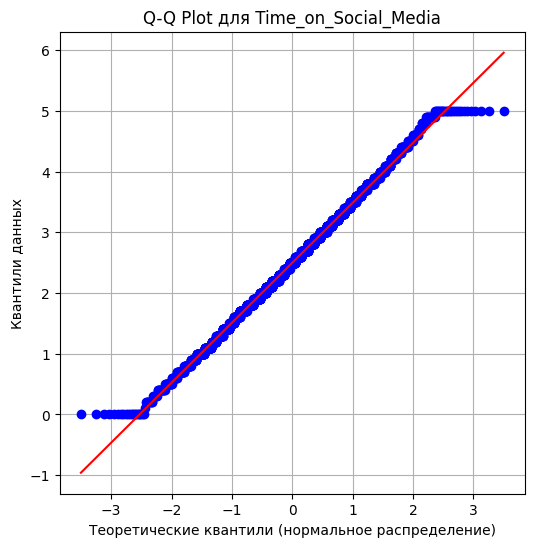

In [79]:
from scipy.stats import probplot

plt.figure(figsize=(6, 6))  # Размер графика
probplot(data_series, dist='norm', plot=plt)
plt.title('Q-Q Plot для Time_on_Social_Media')
plt.xlabel('Теоретические квантили (нормальное распределение)')
plt.ylabel('Квантили данных')
plt.grid(True)
plt.show()

Точки на прямой (y = x): Данные нормальны, так как их квантили совпадают с квантилями нормального распределения.

In [80]:
data_series.isna().sum()

np.int64(0)

Приведение данных к норм распределение через удаление выбросов

In [81]:
Q1 = data_series.quantile(0.25)
Q3 = data_series.quantile(0.75)
IQR = Q3 - Q1
lower_bound = max(0, Q1 - 1.5 * IQR) 
upper_bound = Q3 + 1.5 * IQR 

In [82]:
print(f"Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}")
print(f"Границы выбросов: [{lower_bound:.2f}, {upper_bound:.2f}]")
print(f"Количество выбросов: {((data_series < lower_bound) | (data_series > upper_bound)).sum()} из {len(data_series)}")

Q1: 1.80, Q3: 3.20, IQR: 1.40
Границы выбросов: [0.00, 5.30]
Количество выбросов: 0 из 3000


О нет, нет выбросов... Ну так-то меня только статистика хи-квадрат подводит

Буду делать через стандартизацию

In [83]:
data_stand = (data_series - mean) / std

Характеристики после стандартизирования данных

In [84]:
print("Среднее значение", data_stand.mean())
print("Дисперсия", data_stand.var())
print("Мода", data_stand.mode()[0] if not data_stand.mode().empty else np.nan)
print("Медиана", data_stand.median())
quantilies_stand = data_stand.quantile([0.25, 0.5, 0.75])
print("Квантили", quantilies.values)
print("Эксцесс",stats.kurtosis(data_stand, bias=False))
print("Ассиметрия", stats.skew(data_stand, bias=False))
print("Интерквартильный размах", quantilies_stand[0.75] - quantilies_stand[0.25])

Среднее значение -3.1559939846677783e-16
Дисперсия 1.0
Мода 0.2031637571502606
Медиана 0.0007758204241165746
Квантили [1.8 2.5 3.2]
Эксцесс -0.21322979611749737
Ассиметрия 0.0669729910462573
Интерквартильный размах 1.4167155570830072


Среднее значиние, мода и медиана близки к нулю. Среднее значение особенно => я смогла стандартизировать данные.
Относительно эксцессы и ассиметрии выводы не поменялись, распределение всё ещё близко к нормальному

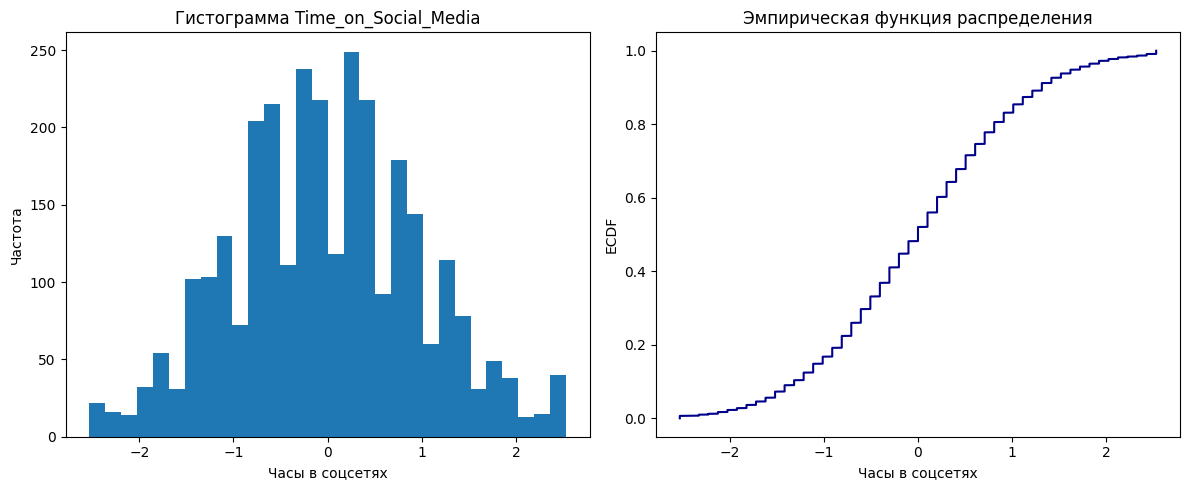

In [86]:
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.hist(data_stand, bins = 30)
plt.title('Гистограмма Time_on_Social_Media')
plt.xlabel('Часы в соцсетях')
plt.ylabel('Частота')

plt.subplot(1, 2, 2)
sorted_data = np.sort(data_stand)
y = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
plt.plot(sorted_data, y, color='darkblue')
plt.title('Эмпирическая функция распределения')
plt.xlabel('Часы в соцсетях')
plt.ylabel('ECDF')

plt.tight_layout()
plt.show()

In [95]:
mean = data_stand.mean()
std = np.sqrt(data_stand.var())
n = len(data_stand)

In [96]:
#Разбиваем данные на интервалы
bins = 30
hist, bin_edges = np.histogram(data_stand, bins = bins, density=False)
observed = hist #наблюдаемые частоты

In [97]:
#Вычисляем ожидаемые частоты
expected = []
for i in range(len(bin_edges) - 1):
    left = bin_edges[i]
    right = bin_edges[i + 1]
    prob = stats.norm.cdf(right, mean, std) - stats.norm.cdf(left, mean, std)
    expected.append(prob * n)


expected = np.array(expected)

In [98]:
if any(e < 5 for e in expected):
    print("Предупреждение: некоторые ожидаемые частоты < 5, попробуйте увеличить bins или объединить интервалы")

In [99]:
#Статистика хи-квадрат
chi_square_stat = np.sum((observed - expected) ** 2 / expected)
df_chi = len(observed) - 1 - 2 #Степени свободы
critical_value = stats.chi2.ppf(1 - 0.05, df_chi) #критическое значение

In [101]:
print("Критерий хи-квадрат:")
print(f"Статистика хи-квадрат: {chi_square_stat:.2f}")
print(f"Критическое значение (alpha=0.05, df={df_chi}): {critical_value:.2f}")
if chi_square_stat > critical_value:
    print("Отвергаем гипотезу о нормальности (данные не нормальны)")
else:
    print("Не отвергаем гипотезу о нормальности")

Критерий хи-квадрат:
Статистика хи-квадрат: 376.75
Критическое значение (alpha=0.05, df=27): 40.11
Отвергаем гипотезу о нормальности (данные не нормальны)
